# PCA 처리에 맞는 KNN

In [2]:
# ============================================================
# 02_train_classical_ml.ipynb
#
# Train classical ML models (KNN, SVM, Decision Tree,
# Random Forest, XGBoost) on Colored MNIST.
#
# - Uses preprocessed features from 01_preprocessing_colored_mnist.ipynb
# - Supports 3 tasks:
#     1) Digit classification (0-9)
#     2) Foreground color classification (7 classes, ROYGBIV)
#     3) Background color classification (7 classes, ROYGBIV)
# ============================================================

import os  # path handling
import numpy as np  # numerical operations
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # nicer plots

from sklearn.metrics import (  # evaluation metrics
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV  # hyperparameter tuning

from sklearn.neighbors import KNeighborsClassifier  # KNN model
from sklearn.svm import SVC  # SVM model
from sklearn.tree import DecisionTreeClassifier  # Decision Tree model
from sklearn.ensemble import RandomForestClassifier  # Random Forest model



# Matplotlib style (English only)
plt.rcParams["font.family"] = "DejaVu Sans"  # default font
plt.rcParams["axes.unicode_minus"] = False  # minus sign
sns.set(style="whitegrid")  # seaborn style

RANDOM_STATE = 42  # global random seed for reproducibility

print("[OK] Libraries imported.")


# ------------------------------------------------------------
# Resolve BASE_DIR and processed npz path
# ------------------------------------------------------------
cwd = os.getcwd()  # current working directory

# If current folder is 'notebooks', use its parent as repo root
if os.path.basename(cwd) == "notebooks":  # check folder name
    BASE_DIR = os.path.dirname(cwd)  # go one level up
else:
    BASE_DIR = cwd  # otherwise use current directory as root

PROCESSED_PATH = os.path.join(
    BASE_DIR, BASE_DIR, "data", "processed", "deskewed_pca_mnist.npz"
)  # path to preprocessed npz

print(f"[INFO] BASE_DIR       : {BASE_DIR}")
print(f"[INFO] PROCESSED_PATH : {PROCESSED_PATH}")

if not os.path.exists(PROCESSED_PATH):  # check if file exists
    raise FileNotFoundError(
        f"[ERROR] Processed file not found at {PROCESSED_PATH}.\n"
        f"Please run 01_preprocessing_colored_mnist.ipynb first."
    )

data = np.load(PROCESSED_PATH)  # load npz file into memory
print("[OK] Loaded npz keys:", list(data.keys()))


# ------------------------------------------------------------
# Extract features (scaled + raw)
#   - X_*     : standardized features (mean=0, std=1) for classical ML
#   - X_*_raw : flattened RGB in [0,1] (for PCA or other future use)
# ------------------------------------------------------------
X_train = data["X_train"].astype(np.float32)  # scaled train features
X_val   = data["X_val"].astype(np.float32)    # scaled val features
X_test  = data["X_test"].astype(np.float32)   # scaled test features

X_train_raw = data["X_train_raw"].astype(np.float32)  # raw train features (0-1)
X_val_raw   = data["X_val_raw"].astype(np.float32)    # raw val features
X_test_raw  = data["X_test_raw"].astype(np.float32)   # raw test features

print("[INFO] Feature shapes (scaled):")
print("  X_train:", X_train.shape)
print("  X_val  :", X_val.shape)
print("  X_test :", X_test.shape)

print("[INFO] Raw features are loaded as well, reserved for future use (e.g., PCA).")

# ------------------------------------------------------------
# Select task: "digit", "fg", or "bg"
# ------------------------------------------------------------

TASK = "digit"  # change to "fg" or "bg" depending on experiment

if TASK == "digit":
    y_train = data["y_train"]  # digit labels for train
    y_val   = data["y_val"]    # digit labels for val
    y_test  = data["y_test"]   # digit labels for test
    class_names = [str(i) for i in range(10)]  # class names "0"~"9"

    print("[TASK] Digit classification (0-9).")



print("[INFO] Label shapes:")
print("  y_train:", y_train.shape)
print("  y_val  :", y_val.shape)
print("  y_test :", y_test.shape)
print("  num_classes:", len(class_names))

[OK] Libraries imported.
[INFO] BASE_DIR       : c:\src\colored-mnist-classification
[INFO] PROCESSED_PATH : c:\src\colored-mnist-classification\data\processed\deskewed_pca_mnist.npz
[OK] Loaded npz keys: ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'X_train_raw', 'X_val_raw', 'X_test_raw']
[INFO] Feature shapes (scaled):
  X_train: (48000, 80)
  X_val  : (6000, 80)
  X_test : (6000, 80)
[INFO] Raw features are loaded as well, reserved for future use (e.g., PCA).
[TASK] Digit classification (0-9).
[INFO] Label shapes:
  y_train: (48000,)
  y_val  : (6000,)
  y_test : (6000,)
  num_classes: 10


In [3]:
# ------------------------------------------------------------
# [Cell 2] Utility function to evaluate a classifier
#   - Trains the model on (X_train, y_train)
#   - Evaluates on both val and test sets
#   - Prints accuracy / precision / recall / F1
#   - Shows confusion matrix for each split
# ------------------------------------------------------------

def evaluate_classifier(model,  # sklearn/xgboost-like estimator
                        model_name: str,
                        X_train, y_train,
                        X_val, y_val,
                        X_test, y_test,
                        class_names):

    print("=" * 60)
    print(f"[MODEL] {model_name}")
    print("=" * 60)

    # --------- Train ---------
    model.fit(X_train, y_train)  # fit classifier on training data
    print("[OK] Training finished.")

    # --------- Validation evaluation ---------
    y_val_pred = model.predict(X_val)  # predictions for validation set
    acc_val = accuracy_score(y_val, y_val_pred)  # validation accuracy
    pr_val, rc_val, f1_val, _ = precision_recall_fscore_support(
        y_val, y_val_pred, average="weighted", zero_division=0
    )  # weighted precision/recall/F1

    print("\n[Val] Metrics:")
    print(f"  Accuracy : {acc_val:.4f}")
    print(f"  Precision: {pr_val:.4f}")
    print(f"  Recall   : {rc_val:.4f}")
    print(f"  F1-score : {f1_val:.4f}")
    print("\n[Val] Classification report:")
    print(classification_report(y_val, y_val_pred, target_names=class_names, zero_division=0))

    cm_val = confusion_matrix(y_val, y_val_pred)  # confusion matrix for validation
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Val Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # --------- Test evaluation ---------
    y_test_pred = model.predict(X_test)  # predictions for test set
    acc_test = accuracy_score(y_test, y_test_pred)  # test accuracy
    pr_test, rc_test, f1_test, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average="weighted", zero_division=0
    )

    print("\n[Test] Metrics:")
    print(f"  Accuracy : {acc_test:.4f}")
    print(f"  Precision: {pr_test:.4f}")
    print(f"  Recall   : {rc_test:.4f}")
    print(f"  F1-score : {f1_test:.4f}")
    print("\n[Test] Classification report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))

    cm_test = confusion_matrix(y_test, y_test_pred)  # confusion matrix for test
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Return dictionary for later summary if needed
    return {
        "model": model,
        "acc_val": acc_val,
        "f1_val": f1_val,
        "acc_test": acc_test,
        "f1_test": f1_test,
    }

[KNN] Starting hyperparameter search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

[KNN] Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
[KNN] Best CV accuracy: 0.9802
[MODEL] KNN
[OK] Training finished.

[Val] Metrics:
  Accuracy : 0.9822
  Precision: 0.9822
  Recall   : 0.9822
  F1-score : 0.9821

[Val] Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       592
           1       0.98      0.99      0.99       674
           2       0.98      0.99      0.99       596
           3       0.98      0.97      0.97       613
           4       0.98      0.98      0.98       584
           5       0.99      0.97      0.98       542
           6       0.99      0.99      0.99       592
           7       0.99      0.99      0.99       627
           8       0.98      0.96      0.97       585
           9       0.97      0.97      0.97       595

    accuracy                        

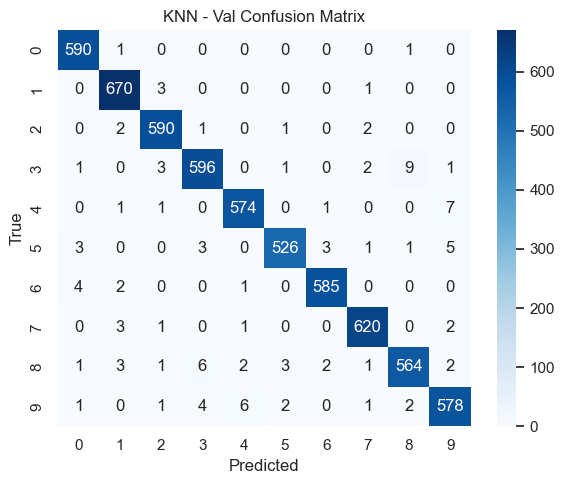


[Test] Metrics:
  Accuracy : 0.9788
  Precision: 0.9789
  Recall   : 0.9788
  F1-score : 0.9788

[Test] Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       593
           1       0.99      0.99      0.99       674
           2       0.97      0.98      0.98       596
           3       0.98      0.98      0.98       613
           4       0.99      0.97      0.98       584
           5       0.97      0.97      0.97       542
           6       0.98      1.00      0.99       592
           7       0.97      0.97      0.97       626
           8       0.98      0.95      0.96       585
           9       0.95      0.98      0.97       595

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



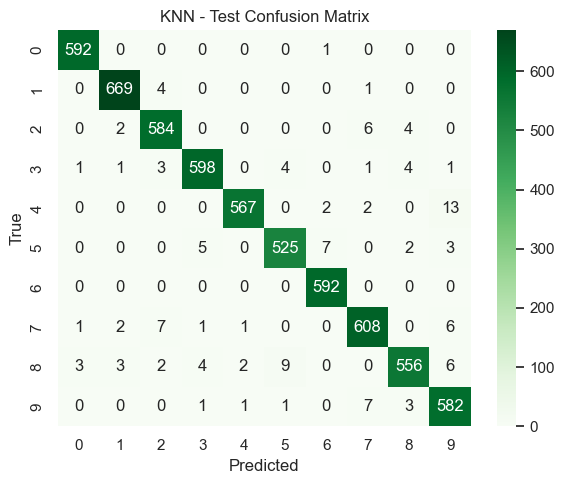

In [4]:
# ------------------------------------------------------------
# [Cell 3] KNN with hyperparameter tuning (GridSearchCV)
#   - Uses scaled features X_train / X_val / X_test
#   - Parameter search over k, weights, and distance metric
# ------------------------------------------------------------

# Define base KNN classifier

knn_base = KNeighborsClassifier(
    n_neighbors=3,
    weights='uniform',
    p=1,
    metric='minkowski',
    n_jobs=-1
)

# default KNN classifier

# Define hyperparameter search space for KNN
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],         # number of neighbors
    "weights": ["uniform", "distance"],  # uniform weights vs distance weights
    "p": [1, 2],                         # 1: Manhattan, 2: Euclidean
}

# GridSearchCV configuration
knn_grid = GridSearchCV(
    estimator=knn_base,     # base KNN model
    param_grid=param_grid_knn,  # parameter search space
    scoring="accuracy",     # optimization metric (can change to 'f1_weighted')
    cv=3,                   # 3-fold cross-validation on training set
    n_jobs=-1,              # use all available CPU cores
    verbose=2,              # print progress
)

print("[KNN] Starting hyperparameter search...")
knn_grid.fit(X_train, y_train)  # fit GridSearchCV on training data


print("\n[KNN] Best parameters:", knn_grid.best_params_)
print("[KNN] Best CV accuracy:", f"{knn_grid.best_score_:.4f}")

# Extract best model from grid search
knn_best = knn_grid.best_estimator_  # best KNN model according to CV

# Evaluate best KNN model using common evaluation function
results_knn = evaluate_classifier(
    model=knn_best,
    model_name="KNN",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    class_names=class_names,
)